
##Giorgio Mendoza

###RBE595-S24-S01

##Kalman Filter Project


#Task 1: Kalman Filter Equations
Using the provided information, determine the matrices used in the process and measurement models. Note, you do not need to include the noise matrices. For the process model, be sure to start from a continuous time model, extract the time step from the data, and use that to create a discrete time model. Note that
in doing this you may treat the drone as a point mass and the input has no constraints on it. This is not realistic but should still yield good results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


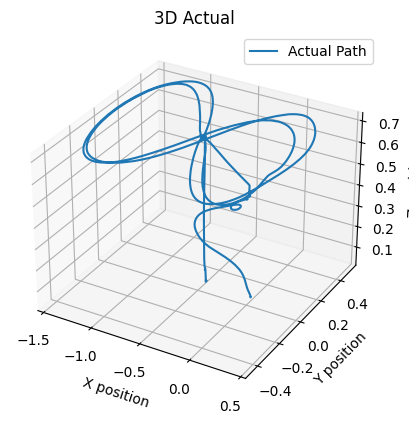

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load actual motion capture data
df_mocap_actual = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_mocap.txt', header=None)

df_mocap_actual.columns = ['t', 'u1', 'u2', 'u3', 'z1_actual', 'z2_actual', 'z3_actual']

# Plot actual path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_mocap_actual['z1_actual'], df_mocap_actual['z2_actual'], df_mocap_actual['z3_actual'], label='Actual Path')

# Plot estimated path
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.title('3D Actual')
ax.legend()
plt.show()

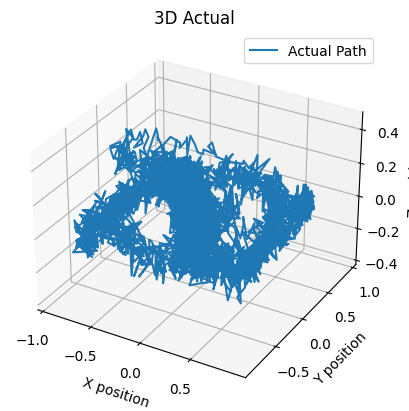

In [3]:
df_mocap_actual = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_velocity.txt', header=None)

df_mocap_actual.columns = ['t', 'u1', 'u2', 'u3', 'z1_actual', 'z2_actual', 'z3_actual']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_mocap_actual['z1_actual'], df_mocap_actual['z2_actual'], df_mocap_actual['z3_actual'], label='Actual Path')

# Plot estimated velocity from Kalman filter output
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.title('3D Actual')
ax.legend()
plt.show()

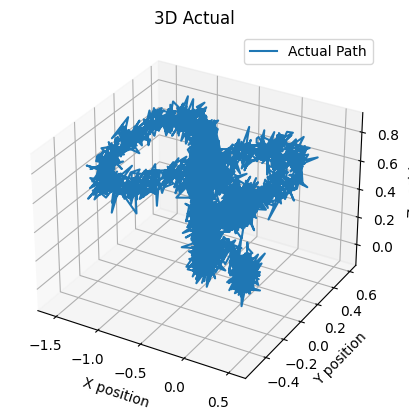

In [4]:
df_mocap_actual = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_low_noise.txt', header=None)

df_mocap_actual.columns = ['t', 'u1', 'u2', 'u3', 'z1_actual', 'z2_actual', 'z3_actual']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_mocap_actual['z1_actual'], df_mocap_actual['z2_actual'], df_mocap_actual['z3_actual'], label='Actual Path')

# Plot estimated position without Kalman filter output
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.title('3D Actual')
ax.legend()
plt.show()

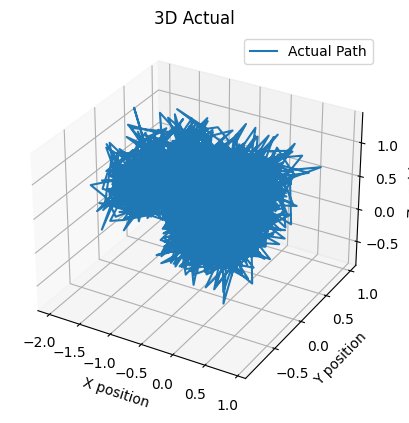

In [5]:
df_mocap_actual = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_high_noise.txt', header=None)

df_mocap_actual.columns = ['t', 'u1', 'u2', 'u3', 'z1_actual', 'z2_actual', 'z3_actual']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_mocap_actual['z1_actual'], df_mocap_actual['z2_actual'], df_mocap_actual['z3_actual'], label='Actual Path')

# Plot estimated position without Kalman filter
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.title('3D Actual')
ax.legend()
plt.show()

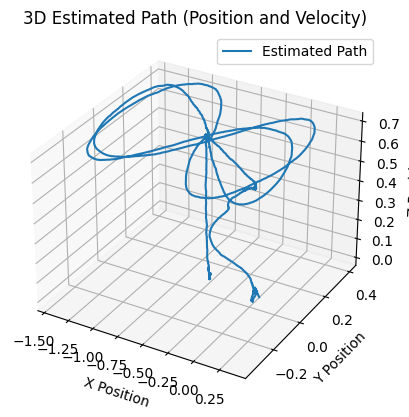

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load position data
df_position = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_low_noise.txt', header=None)
df_position.columns = ['t', 'u1', 'u2', 'u3', 'z1', 'z2', 'z3']

# Load velocity data
df_velocity = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_velocity.txt', header=None)
df_velocity.columns = ['t', 'u1', 'u2', 'u3', 'v1', 'v2', 'v3']

# Define initial state and covariance
initial_state = np.array([0, 0, 0, 0, 0, 0])  # Assuming drone starts at origin at rest
P = np.eye(6) * 1000  # Starting with large uncertainty

# Define delta time
df_velocity['Delta_t'] = df_velocity['t'].diff().fillna(0)
Delta_t = df_velocity['Delta_t'].mean()

# Define state transition matrix (F) and control input matrix (B)
F = np.array([
    [1, 0, 0, Delta_t, 0, 0],
    [0, 1, 0, 0, Delta_t, 0],
    [0, 0, 1, 0, 0, Delta_t],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])
m = 0.027  # Mass of drone in kg
B = np.zeros((6, 3))

# Define process and measurement noise covariance matrices
sigma_process = 0.00045  # we can tune this based on the behavior of the system
Q = np.eye(6) * sigma_process**2

sigma_meas = 0.1  # Measurement noise standard deviation in meters
R = np.eye(6) * sigma_meas**2

# Observation matrix H for position and velocity measurement
H = np.zeros((6, 6))
H[0, 0] = H[1, 1] = H[2, 2] = H[3, 3] = H[4, 4] = H[5, 5] = 1

# Buffer for storing states
states = []

# Ensure velocity DataFrame is aligned with position DataFrame
df_velocity = df_velocity[df_velocity['t'].isin(df_position['t'])]

# Iterate over DataFrame using timestamps from df_position
for t in df_position['t']:
    pos_row = df_position[df_position['t'] == t].iloc[0]
    vel_row = df_velocity[df_velocity['t'] == t].iloc[0]

    # Prediction step
    x_pred = F @ initial_state + B @ np.array([vel_row['u1'], vel_row['u2'], vel_row['u3']])
    P_pred = F @ P @ F.T + Q

    # Measurement update
    z_pos = np.array([pos_row['z1'], pos_row['z2'], pos_row['z3']])
    z_vel = np.array([vel_row['v1'], vel_row['v2'], vel_row['v3']])
    z = np.hstack([z_pos, z_vel])  # Combine position and velocity measurements

    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    initial_state = x_pred + K @ y
    P = (np.eye(6) - K @ H) @ P_pred

    states.append(initial_state)

# Convert states to a DataFrame
states_df = pd.DataFrame(states, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(states_df['x'], states_df['y'], states_df['z'], label='Estimated Path')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
plt.title('3D Estimated Path (Position and Velocity)')
ax.legend()
plt.show()


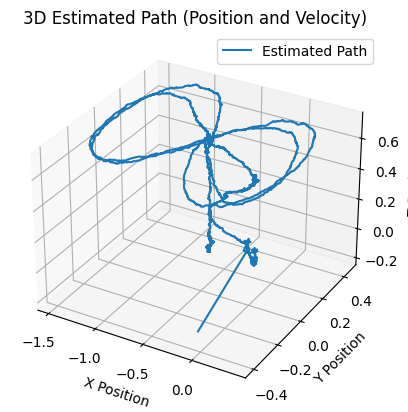

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load position data
df_position = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_high_noise.txt', header=None)
df_position.columns = ['t', 'u1', 'u2', 'u3', 'z1', 'z2', 'z3']

# Load velocity data
df_velocity = pd.read_csv('/content/drive/MyDrive/kalman_filter_data_velocity.txt', header=None)
df_velocity.columns = ['t', 'u1', 'u2', 'u3', 'v1', 'v2', 'v3']

# Define initial state and covariance
initial_state = np.array([0, 0, 0, 0, 0, 0])  # Assuming drone starts at  origin at rest
P = np.eye(6) * 1000  # Starting with large uncertainty

# Define delta time
df_velocity['Delta_t'] = df_velocity['t'].diff().fillna(0)
Delta_t = df_velocity['Delta_t'].mean()

# Define state transition matrix (F) and control input matrix (B)
F = np.array([
    [1, 0, 0, Delta_t, 0, 0],
    [0, 1, 0, 0, Delta_t, 0],
    [0, 0, 1, 0, 0, Delta_t],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])
m = 0.027  # Mass of drone in kg
B = np.zeros((6, 3))

# define process and measurement noise covariance matrices
sigma_process = 0.0006  # we can tune this based on the behavior of the system
Q = np.eye(6) * sigma_process**2

sigma_meas = 0.1  # Measurement noise standard deviation in meters
R = np.eye(6) * sigma_meas**2

# Observation matrix H for position and velocity measurement
H = np.zeros((6, 6))
H[0, 0] = H[1, 1] = H[2, 2] = H[3, 3] = H[4, 4] = H[5, 5] = 1

# Buffer for storing states
states = []

# Ensure velocity DataFrame is aligned with position DataFrame
df_velocity = df_velocity[df_velocity['t'].isin(df_position['t'])]

# Iterate over DataFrame using timestamps from df_position
for t in df_position['t']:
    pos_row = df_position[df_position['t'] == t].iloc[0]
    vel_row = df_velocity[df_velocity['t'] == t].iloc[0]

    # Prediction step
    x_pred = F @ initial_state + B @ np.array([vel_row['u1'], vel_row['u2'], vel_row['u3']])
    P_pred = F @ P @ F.T + Q

    # Measurement update
    z_pos = np.array([pos_row['z1'], pos_row['z2'], pos_row['z3']])
    z_vel = np.array([vel_row['v1'], vel_row['v2'], vel_row['v3']])
    z = np.hstack([z_pos, z_vel])  # Combine position and velocity measurements

    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    initial_state = x_pred + K @ y
    P = (np.eye(6) - K @ H) @ P_pred

    states.append(initial_state)

# Convert states to a DataFrame
states_df = pd.DataFrame(states, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(states_df['x'], states_df['y'], states_df['z'], label='Estimated Path')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
plt.title('3D Estimated Path (Position and Velocity)')
ax.legend()
plt.show()
